In [1]:
%cd '../HOTS'
from Tools import netparam, knn, JensenShannon, BattachaNorm, fit_jitter
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import isfile

/home/antoine/homhots/HOTS/HOTS


In [2]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

# Testing on the full dataset

In [3]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'
dataset = 'nmnist'
nb_train = 60000
nb_test = 10000
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 12
verbose=False

training set size: 60000 - testing set: 10000


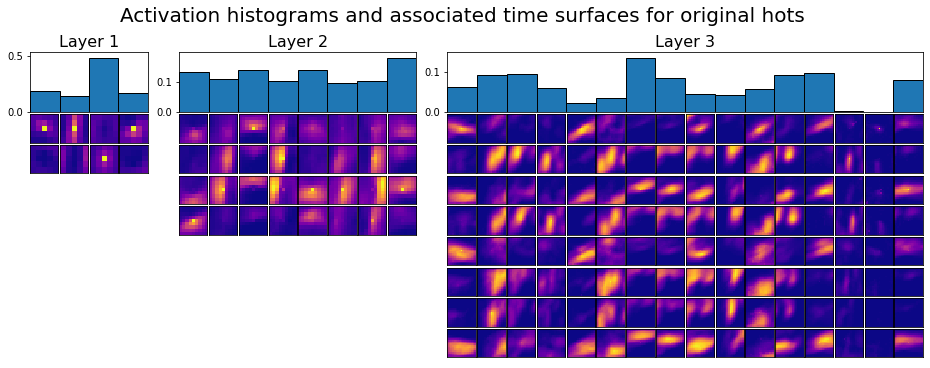

----------Averaged histograms----------
Performances for hots with Euclidian distance: 37.7%
Performances for hots with Bhattacharyya distance: 37.9%
Performances for hots with Jensen-Shannon distance: 37.9%
---------Per sample histograms---------
Performances for hots with  k-NN (k=12): 86.9%


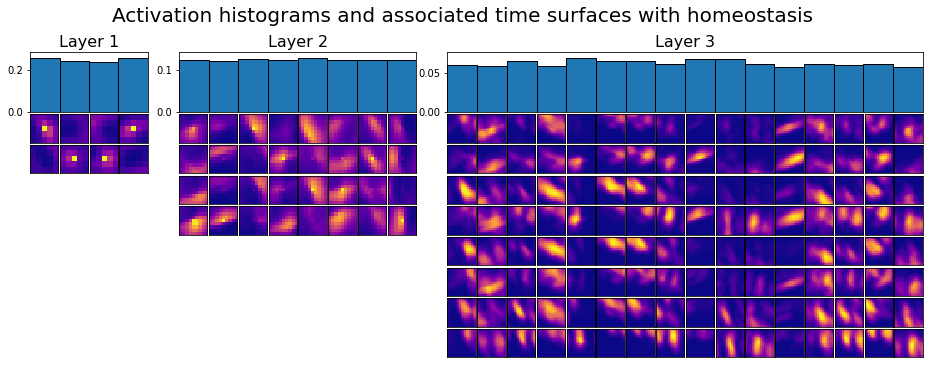

----------Averaged histograms----------
Performances for homhots with Euclidian distance: 44.0%
Performances for homhots with Bhattacharyya distance: 45.800000000000004%
Performances for homhots with Jensen-Shannon distance: 45.9%
---------Per sample histograms---------
Performances for homhots with  k-NN (k=12): 87.7%


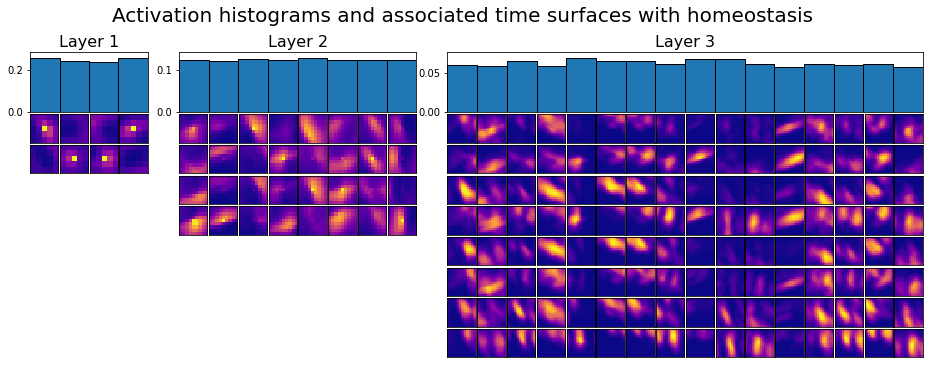

KeyboardInterrupt: 

In [27]:
for name in ['hots', 'homhots', 'fullhom']:
    f_name = f'{record_path}{timestr}_results_fullset_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    hotshom.plotlayer()
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
    else:
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        JS_kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance', metric = JensenShannon)
        kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
        
        trainhistomapav = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        trainhistomapav2 = []
        for i in range(trainhistomapav.shape[0]):
            trainhistomapav2.append([i,trainhistomapav[i,:]])
        JS_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = JensenShannon)
        BA_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = BattachaNorm)
        EU_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform')

        scores = [EU_score, BA_score, JS_score, kNN_score, JS_kNN_score]
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
        
    print('----------Averaged histograms----------')
    print(f'Performances for {name} with Euclidian distance: {np.round(scores[0],3)*100}%')
    print(f'Performances for {name} with Bhattacharyya distance: {np.round(scores[1],3)*100}%')
    print(f'Performances for {name} with Jensen-Shannon distance: {np.round(scores[2],3)*100}%')
    print('---------Per sample histograms---------')
    print(f'Performances for {name} with  k-NN (k={kNN}): {np.round(scores[3],3)*100}%')
    #print(f'Performances for {name} with  k-NN using Jensen-Shannon as a metric (k={kNN}): {np.round(scores[4],3)*100}%')

# Testing on different folds

- trainset is composed of all avaible samples: 60 000 digits
- testset is divided into 10 folds of 1000 samples each

In [18]:
nb_test = 10000
ds = 10
nb_test = nb_test//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 60000 - testing set: 1000


In [6]:
verbose = False
for name in ['hots','homhots']:
    f_name = f'{record_path}{timestr}_results_kfolds_{nb_test}_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo', verbose = verbose)
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
        print('results loaded')
    else:
        scores = []
        for i in range(ds):
            testhistomap = hotshom.running(homeotest=homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, kfold = ds, kfold_ind=i, verbose=verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            scores.append(kNN_score)
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
    print(f'Mean accuracy for {name} = {np.round(np.mean(scores),3)*100}% - std = {np.round(np.std(scores),3)*100}')

results loaded
Mean accuracy for hots = 87.0% - std = 1.0
results loaded
Mean accuracy for homhots = 87.9% - std = 1.4000000000000001


# Testing with different spatial and temporal jitter

- trainset is composed of all avaible samples: 60 000 digits
- testset is a subset composed of 1000 samples of the N-MNIST testset
- spatial and temporal jitter are applied separately to the testset

In [19]:
from scipy.stats import beta

jit_s = np.arange(0,10,0.5)
jit_t = np.arange(0,300,10)
jit_s, jit_t = jit_s**2, jit_t**2

nb_trials = 10

results loaded
../Records/EXP_03_NMNIST/train/2021-03-29_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_60000_[None, None]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_1000_[None, 0.0]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_1000_[None, 0.25]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_1000_[None, 1.0]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_1000_[None, 2.25]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_True_1000_[None, 4.0]_histo.pkl
../Records/EXP_03_NMNIST/test/2021-03-29_0_lagorce_first_None_False_[0.25, 1]_[4, 

KeyboardInterrupt: 

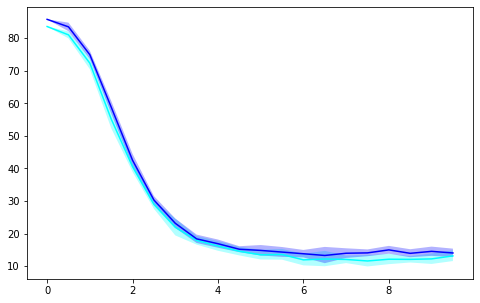

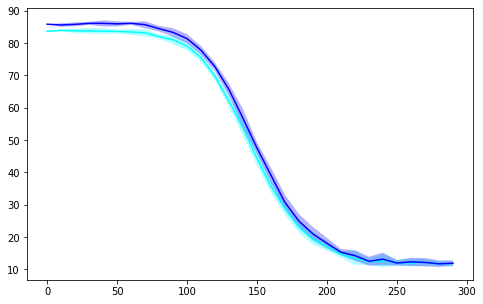

In [24]:
verbose = True
fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))

for name in ['homhots', 'hots']:
    f_name = f'{record_path}{timestr}_results_jitter_{nb_test}_histo_{name}.pkl'
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            score_t1, score_t12, jit_t, score_s1, score_s12, jit_s = pickle.load(file)
        print('results loaded')
    else:
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo')
        score_s1 = np.zeros([nb_trials, len(jit_s)])
        score_t1 = np.zeros([nb_trials, len(jit_t)])
        score_s12 = np.zeros([nb_trials, len(jit_s)])
        score_t12 = np.zeros([nb_trials, len(jit_t)])
        for trial in range(nb_trials):
            hotshom.date = '2021-03-29_'+str(trial)
            id_jit = 0
            for i in jit_s:
                i = round(i,2)
                jitonic = [None,i]
                #if isfile(f'{record_path}/test/'+hotshom.get_fname()+f'_{nb_test}_{jitonic}_histo.pkl'):
                testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
                kNN12_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
                kNN1_score = knn(trainhistomap,testhistomap, k = 1, weights = 'distance')
                score_s1[trial,id_jit] = kNN1_score
                score_s12[trial,id_jit] = kNN12_score
                id_jit+=1
                
            id_jit = 0
            for j in jit_t:
                j = round(j,0)
                jitonic = [j,None]
                #if isfile(f'{record_path}/test/'+hotshom.get_fname()+f'_{nb_test}_{jitonic}_histo.pkl'):
                testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, subset_size = nb_test, verbose = verbose)
                kNN12_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
                kNN1_score = knn(trainhistomap,testhistomap, k = 1, weights = 'distance')
                score_t1[trial,id_jit] = kNN1_score
                score_t12[trial,id_jit] = kNN12_score
                id_jit+=1
                
        with open(f_name, 'wb') as file:
            pickle.dump([score_t1, score_t12, jit_t, score_s1, score_s12, jit_s], file, pickle.HIGHEST_PROTOCOL)
            
    jit_t_plot, jit_s_plot = np.sqrt(jit_t), np.sqrt(jit_s)
    
    missing = np.where(score_t12==0)
    for i in range(len(missing[0])):
        score_t12[missing[0][i],missing[1][i]]=score_t12[missing[0][i]-1,missing[1][i]]
    missing = np.where(score_s12==0)
    for i in range(len(missing[0])):
        score_s12[missing[0][i],missing[1][i]]=score_s12[missing[0][i]-1,missing[1][i]]
    
    score_stat1 = np.zeros([3,len(jit_t)])
    score_stat12 = np.zeros([3,len(jit_t)])
    score_stas1 = np.zeros([3,len(jit_s)])
    score_stas12 = np.zeros([3,len(jit_s)])
    q = [0.05,0.5,0.95]
    for i in range(1,score_t1.shape[1]):
        mean = np.mean(score_t1[:,i])
        var = np.std(score_t1[:,i])
        alpha1=mean**2*(1-mean)/var-mean
        beta1=alpha1*(1-mean)/mean
        mean = np.mean(score_t12[:,i])
        var = np.std(score_t12[:,i])
        alpha12=mean**2*(1-mean)/var-mean
        beta12=alpha1*(1-mean)/mean
        paramz_t1 = beta.fit(score_t1[:,i], a=alpha1, b=beta1, floc=0, fscale = 1)
        paramz_t12 = beta.fit(score_t12[:,i], a=alpha12, b=beta12, floc=0, fscale = 1)
        score_stat1[0,i], score_stat1[1,i], score_stat1[2,i] = beta.ppf(q, a=paramz_t1[0], b=paramz_t1[1])
        score_stat12[0,i], score_stat12[1,i], score_stat12[2,i] = beta.ppf(q, a=paramz_t12[0], b=paramz_t12[1])
    for j in range(1,score_s1.shape[1]):
        mean = np.mean(score_s1[:,j])
        var = np.std(score_s1[:,j])
        alpha1=mean**2*(1-mean)/var-mean
        beta1=alpha1*(1-mean)/mean
        mean = np.mean(score_s12[:,j])
        var = np.std(score_s12[:,j])
        alpha12=mean**2*(1-mean)/var-mean
        beta12=alpha1*(1-mean)/mean
        paramz_s1 = beta.fit(score_s1[:,j], a=alpha1, b=beta1, floc=0, fscale = 1)
        paramz_s12 = beta.fit(score_s12[:,j], a=alpha12, b=beta12, floc=0, fscale = 1)
        score_stas1[0,j], score_stas1[1,j], score_stas1[2,j] = beta.ppf(q, a=paramz_s1[0], b=paramz_s1[1])
        score_stas12[0,j], score_stas12[1,j], score_stas12[2,j] = beta.ppf(q, a=paramz_s12[0], b=paramz_s12[1])
    
    score_stat1[:,0] = score_t1[0,0]
    score_stat12[:,0] = score_t12[0,0]
    score_stas1[:,0] = score_s1[0,0]
    score_stas12[:,0] = score_s12[0,0]
    
    if name=='hots':
        ax_s.plot(jit_s_plot, score_stas1[1,:]*100, '-',color='orange', label='HOTS (k=1)')
        ax_s.fill_between(jit_s_plot,
            score_stas1[2,:]*100, score_stas1[0,:]*100,
            facecolor = 'orange', edgecolor = None, alpha = .3)
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '-',color='red', label='HOTS (k=12)')
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat1[1,:]*100, '-',color='orange', label='HOTS (k=1)')
        ax_t.fill_between(jit_t_plot,
            score_stat1[2,:]*100, score_stat1[0,:]*100,
            facecolor = 'orange', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '-',color='red', label='HOTS (k=12)')
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'red', edgecolor = None, alpha = .3)
    else:
        ax_s.plot(jit_s_plot, score_stas1[1,:]*100, '-',color='cyan', label='HOTS with homeostasis (k=1)')
        ax_s.fill_between(jit_s_plot,
            score_stas1[2,:]*100, score_stas1[0,:]*100,
            facecolor = 'cyan', edgecolor = None, alpha = .3)
        
        ax_s.plot(jit_s_plot, score_stas12[1,:]*100, '-',color='blue', label='HOTS with homeostasis (k=12)')
        ax_s.fill_between(jit_s_plot,
            score_stas12[2,:]*100, score_stas12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat1[1,:]*100, '-',color='cyan', label='HOTS with homeostasis (k=1)')
        ax_t.fill_between(jit_t_plot,
            score_stat1[2,:]*100, score_stat1[0,:]*100,
            facecolor = 'cyan', edgecolor = None, alpha = .3)
        
        ax_t.plot(jit_t_plot, score_stat12[1,:]*100, '-',color='blue', label='HOTS with homeostasis (k=12)')
        ax_t.fill_between(jit_t_plot,
            score_stat12[2,:]*100, score_stat12[0,:]*100,
            facecolor = 'blue', edgecolor = None, alpha = .3)
    
chance_s = np.ones([len(jit_s_plot)])*10
ax_s.plot(jit_s_plot,chance_s, 'k--', label='chance level')
chance_t = np.ones([len(jit_t_plot)])*10
ax_t.plot(jit_t_plot,chance_t, 'k--', label='chance level')
ax_t.axis([0,max(jit_t_plot),0,100]);
ax_t.set_xlabel('standard deviation of temporal jitter (in $\mu s$)', fontsize=16);
plt.yticks([],[])
ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
ax_t.legend(fontsize=12);

ax_s.axis([0,max(jit_s_plot),0,100]);
ax_s.set_xlabel('standard deviation of spatial jitter (in pixel)', fontsize=16);
ax_s.set_ylabel('accuracy (in %)', fontsize=16);
ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
ax_s.legend(fontsize=12);

In [9]:
printfig(fig_s, 'spatial_jitter.pdf')
printfig(fig_t, 'temporal_jitter.pdf')

# Online classification

In [8]:
from Tools import classification_results
from scipy.optimize import curve_fit

def fitting(x, a, b):
    return 1-np.exp(-(b*x)**a)

In [5]:
f_name = '../Records/EXP_03_NMNIST/2021-03-29_LR_results_[4, 8, 16]_60000_10000_1.pkl'
with open(f_name, 'rb') as file:
    results = pickle.load(file)
name = ['homhots', 'hots', 'raw']

In [6]:
nb_test = 10000

mean accuracy for homhots = 93.10000000000001%
last event accuracy for homhots = 93.60000000000001%
mean accuracy for hots = 93.0%
last event accuracy for hots = 94.0%
mean accuracy for raw = 43.1%
last event accuracy for raw = 36.7%


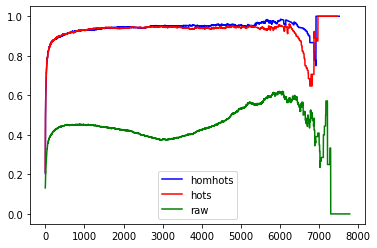

In [10]:
color = ['b', 'r', 'g']
for i in range(3):
    pred_target, true_target, mean_acc, online_acc = results[0][i][0], results[0][i][1], results[0][i][2], results[0][i][3]
    meanac, onlinac,lastac = classification_results(pred_target, true_target, nb_test)
    #pars_hots, cov_hots = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[0.1,2], bounds=(-np.inf, np.inf))

    plt.plot(onlinac, color= color[i], label=name[i])
    #plt.plot(fitting(np.arange(len(onlinac)), *pars_hots), color= color[i], alpha = 0.5)
    plt.legend()
    print(f'mean accuracy for {name[i]} = {np.round(meanac,3)*100}%')
    print(f'last event accuracy for {name[i]} = {np.round(lastac,3)*100}%')